Train a deep MLP on the MNIST dataset (you can load it using tf.keras.datasets.mnist.load_data(). See if you can get over 98% accuracy by manually tuning the hyperparameters. Try searching for the optimal learning rate by using the approach presented in this chapter (i.e., by growing the learning rate exponentially, plotting the loss, and finding the point where the loss shoots up). Next, try tuning the hyperparameters using Keras Tuner with all the bells and whistles—save checkpoints, use early stopping, and plot learning curves using TensorBoard.

In [9]:
# prompt: mount drice

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [1]:
# Import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load the MNIST dataset
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# Split the dataset into training and validation sets, and normalize pixel values to the range [0, 1]
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

11490434/11490434 [==============================] - 0s 0us/step


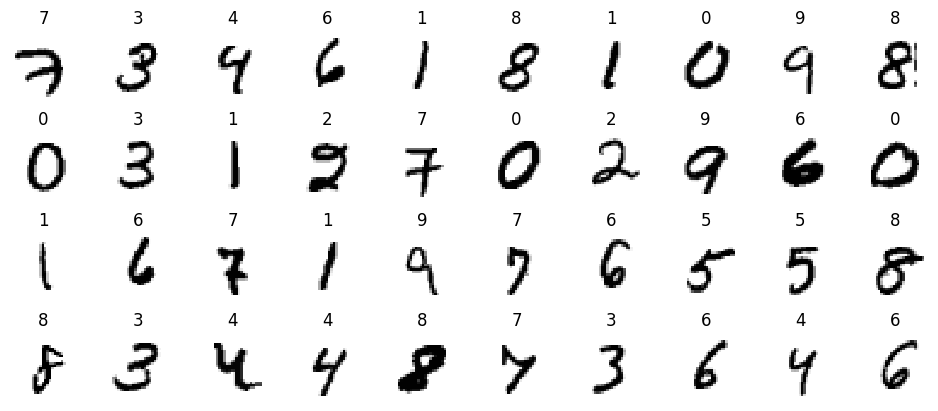

In [2]:
# Set the number of rows and columns for displaying a grid of sample images
n_rows = 4
n_cols = 10

# Create a figure for plotting the images
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))

# Loop over the rows and columns to plot sample images from the training set
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col  # Calculate the index of the image
        plt.subplot(n_rows, n_cols, index + 1)  # Create a subplot for each image
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")  # Display the image in grayscale
        plt.axis('off')  # Turn off axis labels and ticks
        plt.title(y_train[index])  # Display the label of the image

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.2, hspace=0.5)

# Show the plot
plt.show()

In [3]:
# Import the Keras backend for setting and getting learning rates
K = tf.keras.backend

# Define a custom callback for exponential learning rate scheduling
class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor  # Multiplicative factor for the learning rate
        self.rates = []  # List to store learning rates
        self.losses = []  # List to store losses

    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))  # Store the current learning rate
        self.losses.append(logs["loss"])  # Store the loss for the current batch
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)  # Update the learning rate

In [4]:
# Clear any previous TensorFlow graphs
tf.keras.backend.clear_session()

# Set the random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Build a Sequential model with three dense layers
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),  # Flatten the input images (28x28 pixels) into 1D arrays
    tf.keras.layers.Dense(300, activation="relu"),  # Fully connected layer with 300 units and ReLU activation
    tf.keras.layers.Dense(100, activation="relu"),  # Fully connected layer with 100 units and ReLU activation
    tf.keras.layers.Dense(10, activation="softmax")  # Output layer with 10 units (one for each class) and softmax activation
])

In [5]:
# Define the optimizer with a small learning rate
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)

# Compile the model with sparse categorical cross-entropy loss and accuracy metric
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Instantiate the custom callback with a factor for exponential learning rate increase
expon_lr = ExponentialLearningRate(factor=1.005)

# Train the model for 1 epoch with the custom learning rate callback
history = model.fit(X_train, y_train, epochs=1, validation_data=(X_valid, y_valid), callbacks=[expon_lr])

1719/1719 [==============================] - 11s 6ms/step - loss: nan - accuracy: 0.6124 - val_loss: nan - val_accuracy: 0.0958


Text(0, 0.5, 'Loss')

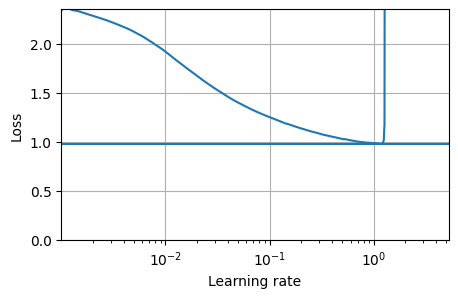

In [7]:
plt.figure(figsize=(5, 3))

plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

since  the loss "starts shooting back up violently" as the learning rate increases beyond a certain point, it indicates that the learning rate has become too high. In this case, 6e-1 so lets reduce it by half.

In [12]:
from pathlib import Path
# Clear any previous TensorFlow graphs
tf.keras.backend.clear_session()

# Set the random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Build a Sequential model with three dense layers
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),  # Flatten the input images (28x28 pixels) into 1D arrays
    tf.keras.layers.Dense(300, activation="relu"),  # Fully connected layer with 300 units and ReLU activation
    tf.keras.layers.Dense(100, activation="relu"),  # Fully connected layer with 100 units and ReLU activation
    tf.keras.layers.Dense(10, activation="softmax")  # Output layer with 10 units (one for each class) and softmax activation
])

# Define the optimizer with a reduced learning rate
optimizer = tf.keras.optimizers.SGD(learning_rate=3e-1)
# Compile the model with sparse categorical cross-entropy loss and accuracy metric
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
# Set the run index for logging purposes
run_index = 1  # Increment this at every run
# Define the directory for storing TensorBoard logs
run_logdir = Path("/content/drive/MyDrive/notebooks") / "mnist_logs" / "run_{:03d}".format(run_index)
# Display the run log directory path
print(run_logdir)

# Set up callbacks for early stopping, model checkpointing, and TensorBoard logging
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_mnist_model", save_best_only=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

# Train the model
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])


/content/drive/MyDrive/notebooks/mnist_logs/run_001
Epoch 1/100
1719/1719 [==============================] - 11s 6ms/step - loss: 0.2319 - accuracy: 0.9269 - val_loss: 0.1140 - val_accuracy: 0.9652
Epoch 2/100
1719/1719 [==============================] - 13s 7ms/step - loss: 0.0949 - accuracy: 0.9705 - val_loss: 0.0863 - val_accuracy: 0.9768
Epoch 3/100
1719/1719 [==============================] - 12s 7ms/step - loss: 0.0640 - accuracy: 0.9795 - val_loss: 0.0847 - val_accuracy: 0.9772
Epoch 4/100
1719/1719 [==============================] - 11s 6ms/step - loss: 0.0484 - accuracy: 0.9841 - val_loss: 0.0787 - val_accuracy: 0.9796
Epoch 5/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0357 - accuracy: 0.9884 - val_loss: 0.0792 - val_accuracy: 0.9778
Epoch 6/100
1719/1719 [==============================] - 11s 6ms/step - loss: 0.0309 - accuracy: 0.9894 - val_loss: 0.0809 - val_accuracy: 0.9768
Epoch 7/100
1719/1719 [==============================] - 11s 6ms/step - l